# DTSA 5510 - Peer-graded Assignment: Week 4: NLP Disaster Tweets Kaggle Mini-Project

## Step 1: Brief description of the problem and data
`Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.`

This week's mini project will be concerned with the Kaggle Competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview). The premise of the competition is that social media is a very important tool during times of crisis. If we were able to automatically sort which tweets are about actual emergencies, we would be able to coordinate an emergency response quicker and more efficently. The goal of this project is to use Machine Learning and Natural Language Processing (NLP) techniques to identify which tweets are about actual emergencies. Natural Language Processing refers to the process by which a computer can interpret speech or text written by humans. The Kaggle competition cites this project as a good starting point for early career data scientists to begin with NLP.

Lets start by loading in some helpful packages:

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Embedding,GlobalAveragePooling1D
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler as sc
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bstrub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bstrub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bstrub\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


After that, lets load the data:

In [145]:
fp = "C:/Users/bstrub/Documents/ml/week4miniproject/nlp-getting-started/"
train = pd.read_csv(fp + "train.csv")
test = pd.read_csv(fp + "test.csv")

Now that we have the data loaded, we can start with basic data inspection. We will look at the head and tail of each data set, as well as use the python functions "info()" and "describe" to get the data types and non-null counts, as well as some basic statistics of the distributions of the numerical variables.

In [3]:
print(train.info())
print(train.describe())
print(train.head())
print(train.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shel

In [4]:
print(test.info())
print(test.describe())
print(test.head())
print(test.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
                 id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in Ch

## Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

`Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?`

### Inspect
A couple of things jump out at me when I *inspect* the training data:
1) There are 7613 distinct tweets in the dataset. This is a little bit smaller than I expected given that when I have covered NLP in other classes we have worked with much larger N's. Having said that, this should make the models run faster so I'm not complaining.
2) The data types are all what I expected them to be. Integers are integers as appropriate and objects are objects. Someone has clearly spent time already curating this data and has done a good job.
3) Having said 2), there is a lot of missing-ness in this data. About 2500 out of 7613 tweets, or 1/3 of tweets, are missing location data. This is leads me to think that we should leave location out of the analysis. Likewise, the test data is missing a similar proportion of location data. For the purposes of this assignment, however, we will still look at visualizations of this data.
4) The "keyword" variable is also missing some data, although not as much as "location". I will be tokenizing the tweets to aid in our models which will likely render the keywords duplicative, so I think we should also leave "keyword" out of hte analysis.
5) There is a lot of "junk" characters in the tweets, as one would expect. There are links to outside tweets, hashtags, colons, semi-colons, emojis, etc. The analysis will be much improved if we get rid of these junk characters.

### Visualize

I have few ideas for visualizations based on my initial scoping of the data. First, I want to look at simply which locations show up the most, which we can accomplish by a barchart. To keep the barchart reasonable, lets look at the top 10 locations

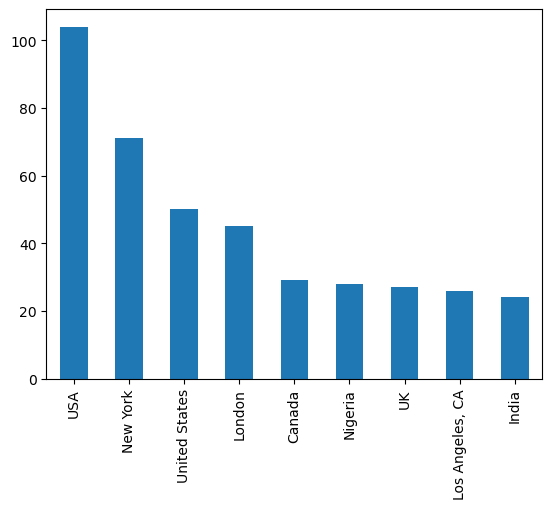

In [5]:
loccounts = train['location'].value_counts()
loccounts = loccounts[0:9].plot(kind = 'bar')

The above plot supports my decision to not include location data in the model. There would have to be a ton of manual recoding to map places like "New York" to "USA" and "London" to "UK" and so on. Also, we would have to map up to the country level, which based on my previous modeling expereince, would be too high level to make any sort of difference in a model. 

Now, let's do the same thing for keyword but expand to the top 20 keywords.

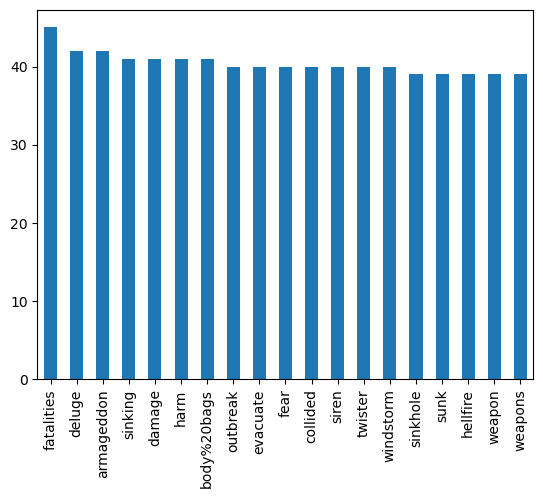

In [6]:
keycounts = train['keyword'].value_counts()
keycounts = keycounts[0:19].plot(kind = 'bar')

Based on this visualization is an argument to be made that keywords should be included in the model, however like I previously mentioned, we will be tokenizing all of the tweets which will render the "keyword" variable redundant. It would be appropriate to end our visualization step here and move on to the cleaning step.

### Clean

For the first step of cleaning, I want to remove all of the columns that we don't need:


In [147]:
train = train.drop(['keyword','location'],axis = 1) 
print(train.head())

test =  test.drop(['keyword','location'],axis = 1) 
print(test.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
   id                                               text  target
0   0                 Just happened a terrible car crash       1
1   2  Heard about #earthquake is different cities, s...       1
2   3  there is a forest fire at spot pond, geese are...       1
3   9           Apocalypse lighting. #Spokane #wildfires       1
4  11      Typhoon Soudelor kills 28 in China and Taiwan       1


Now that is done, we can move on to the tweets themselves. I will be following a structure similar to my Network Analysis for Marketing Analytics class. That means, for the tweets we want to:

1) get rid of the "junk" characters that I referred to earlier 

2) change characters to lowercase

3) lemmatize

4) remove whitespace


In [148]:
startTime = time.time()

def cleantweets(variable):
    
    cleanedtweets = []
    
    for tweet in variable:
        
        # clean things
        tweet = re.sub('[^a-zA-Z]', ' ', tweet)
        tweet = tweet.lower()
        tweet = re.sub(' +', ' ', tweet)
        tweet = tweet.strip()
        
        # remove stop words
        tweet = (tweet.lower()).split()
        newtweet = []
        for word in tweet:
            if word not in stopwords.words('english'):
                newtweet.append(word)
        tweet = newtweet
        
        # lemmatize
        newtweet = []
        lemma = WordNetLemmatizer()
        for word in range(0,len(tweet)):
            if len(tweet[word]) > 2:
                newtweet.append(lemma.lemmatize(tweet[word]))
            else:
                newtweet.append(tweet[word])
                
        tweet = " ".join(newtweet)
        
        cleanedtweets.append(tweet)
    
    return cleanedtweets


train['cleanedtweet'] = cleantweets(train['text'])
test['cleanedtweet'] = cleantweets(test['text'])
endTime = time.time()
print(endTime - startTime)

135.1673777103424


Now that our cleaning code has finished running, lets take a look and see what the data looks like:

In [9]:
print(train.head())
print(test.head())
print(train.info())
print(test.info())

   id                                               text  target  \
0   1  Our Deeds are the Reason of this #earthquake M...       1   
1   4             Forest fire near La Ronge Sask. Canada       1   
2   5  All residents asked to 'shelter in place' are ...       1   
3   6  13,000 people receive #wildfires evacuation or...       1   
4   7  Just got sent this photo from Ruby #Alaska as ...       1   

                                        cleanedtweet  
0        deed reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  
   id                                               text  \
0   0                 Just happened a terrible car crash   
1   2  Heard about #earthquake is different cities, s...   
2   3  there is a forest fire at spot pond, geese are...   
3   9           Apoca

### Plan of analysis
Since this is the week 4 assignment, my plan of analysis will be to train an RNN. We will use a method to process texts to matrix form called TF-IDF. For the modelling step, I will create LSTM and RNN models for comparison and analysis. 

## Step 3: Model Architecture

### TF-IDF
Let's start this step by putting our tweets into matrix form using TF-IDF, which stands for "Term Frequency - Inverse Document Frequency". At it's foundation TF-IDF looks at a of word within a string and compares it's importance in the string to a set of other strings. In our data this would mean seeing how "important" a word in a tweet is when compared to our entire set of tweets. Since this is not covered in any of the lectures but is required in the assignment I will be following along at [here](https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/#:~:text=Using%20scikit%2Dlearn-,What%20is%20TF%2DIDF%3F,%2C%20relative%20to%20a%20corpus) at learndatasci.com. All credit goes to them for my knowledge here.

I could use that webpage to type out all of the code by hand or I could use TfidfVectorizer from sklearn to make the code more concise, which I will do here now.

In [10]:
alltweets = train['cleanedtweet'].tolist()
v = TfidfVectorizer(max_features=1000)
vectorized = v.fit(alltweets)
tfidftweets = v.transform(train['cleanedtweet']).todense()

In [11]:
tfidftweets

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.40389334, 0.        , ..., 0.        , 0.        ,
         0.        ]])

### Model 1: LSTM Model V1
Now that we have TF-IDF completed, lets move on to actually training some models. In order to display a variety of modelling approaches we'll run LSTM and RNN models. Before we do that however, we need to split our training data even further so we have some data on which to analyze our modelling approaches:

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(tfidftweets, train["target"], test_size=0.2, random_state=42)
xfinaltest = vectorized.transform(test["text"]).todense()

Alright now lets actually build the LSTM Model. Credit to [datacamp.com](https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network) and [Medium.com](https://medium.com/mlearning-ai/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad) for the explainer on using python/tensorflow LSTM architecture. 

In [46]:
features = 1
nsteps = 1000
nepochs = 10
xtrain = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],features)

In [47]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="sigmoid", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model_lstm.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3)
predicted = model_lstm.fit(xtrain,y = ytrain, validation_data = (xtest, ytest),epochs = nepochs,callbacks =[early_stop])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 125)               63500     
                                                                 
 dense_15 (Dense)            (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 170s 873ms/step - loss: 0.7023 - accuracy: 0.5333 - val_loss: 0.7132 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 167s 874ms/step - loss: 0.6935 - accuracy: 0.5458 - val_loss: 0.6872 - val_accuracy: 0.5739
Epoch 3/10
191/191 [==============================] - 169s 885ms/step - loss: 0.6914 - accuracy: 0.5525 - val_loss: 0.6

In [48]:
model.evaluate(xtest, ytest)

48/48 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5739


[0.6822521090507507, 0.5738673806190491]

## Step 4: Results and Analysis

The following plot code is borrowed from [Stack Overflow](https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model)

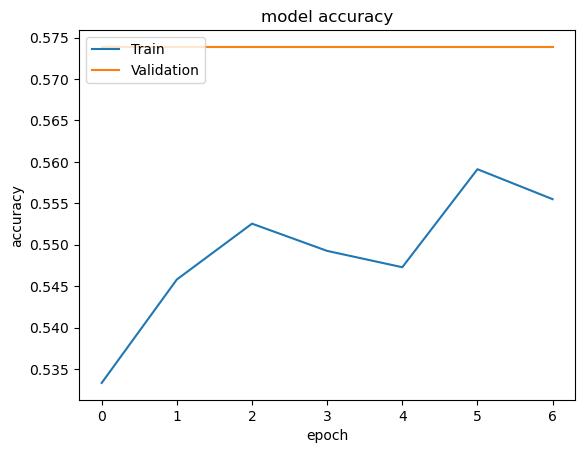

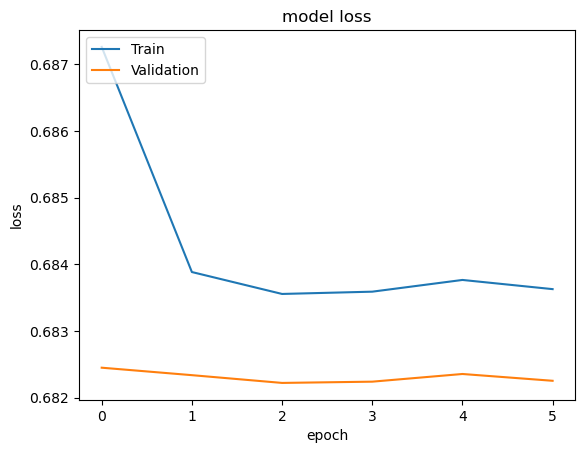

In [52]:
plt.plot(predicted.history['accuracy'])
plt.plot(predicted.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

So that wasn't great. The model did show steady improvement as the epochs increased but we're still not that much better off than flipping a coin to decide what tweets are related to actual disasters. The validation accuracy suggests to me that something is seriously wrong with the model architecture. Let's try to fix that by **tuning some hyperameters** by adding some more layers:

### Model 2: LSTM Model V2

In [68]:
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
max_len = 1000
# Define Dense Model Architecture
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_size,embedding_dim,input_length = max_len))
model_lstm2.add(GlobalAveragePooling1D())
model_lstm2.add(Dense(24, activation='relu'))
model_lstm2.add(Dropout(drop_value))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model_lstm2.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3)
predicted = model_lstm2.fit(xtrain,y = ytrain, validation_data = (xtest, ytest),epochs = nepochs,callbacks =[early_stop])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 1000, 16)          8000      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense_27 (Dense)            (None, 24)                408       
                                                                 
 dropout_11 (Dropout)        (None, 24)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

## Step 4: Results and Analysis (cont.)

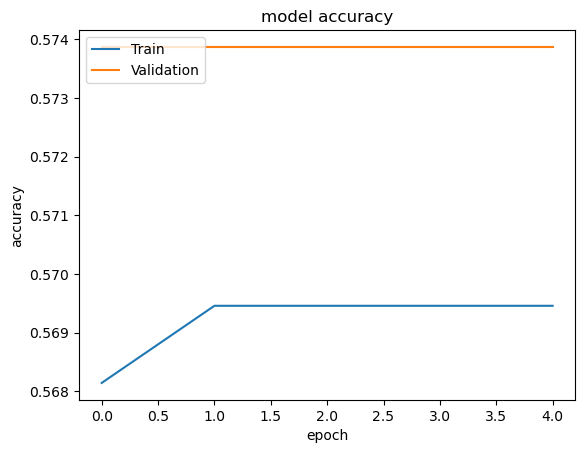

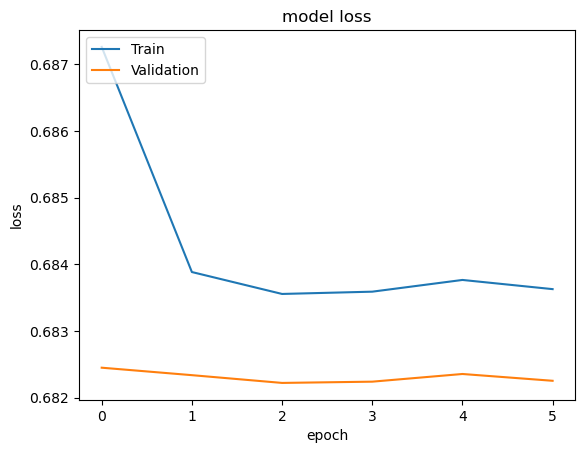

In [73]:
plt.plot(predicted.history['accuracy'])
plt.plot(predicted.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Even after doing more research into the modeling strategy and rerunning, we're still doing poorly. This leads me to conclude that the LSTM approach will not work for this problem and we need to change tactics. 

### Model 3: RNN model

In order to use the RNN model architecture contained in tensorflow, we need to do some further data manipulation. Code adapted from [Medium](https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168) (again) and [Tensorflow's documentation](https://www.tensorflow.org/text/tutorials/text_classification_rnn). For this run, we're going to forgo the TF-IDF object that we created earlier and use the encoder contained from tensorflow.

In [101]:
xtrain, xtest, ytrain, ytest = train_test_split(train['cleanedtweet'], train["target"], test_size=0.2, random_state=42)

traindf = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(xtrain.values, tf.string),
            tf.cast(ytrain.values, tf.int32)
        )
    )
)
traindf = traindf.batch(10)

testdf = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(xtrain.values, tf.string),
            tf.cast(ytrain.values, tf.int32)
        )
    )
)
testdf = testdf.batch(10)

submitdf = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test['cleanedtweet'].values, tf.string)
        )
    )
)
submitdf = submitdf.batch(10)

num_words = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens = num_words)
encoder.adapt(traindf.map(lambda cleanedtweet, label: cleanedtweet))

Alrighty, now we're actually ready to run the model.

In [103]:
model_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    input_dim = len(encoder.get_vocabulary()),
    output_dim = 128,
    mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")])

ed = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate =.00005,decay_steps = 1000,decay_rate=0.9) 
    
model_rnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = ed),loss = "binary_crossentropy",metrics = ["accuracy"])

predicted = model_rnn.fit(traindf,validation_data = testdf,epochs = 100,callbacks = [early_stop])

Epoch 1/100
609/609 [==============================] - 43s 37ms/step - loss: 0.6819 - accuracy: 0.5749 - val_loss: 0.6670 - val_accuracy: 0.6304
Epoch 2/100
609/609 [==============================] - 16s 26ms/step - loss: 0.6256 - accuracy: 0.6961 - val_loss: 0.5226 - val_accuracy: 0.7770
Epoch 3/100
609/609 [==============================] - 16s 26ms/step - loss: 0.4957 - accuracy: 0.7913 - val_loss: 0.4359 - val_accuracy: 0.8204
Epoch 4/100
609/609 [==============================] - 16s 26ms/step - loss: 0.4454 - accuracy: 0.8182 - val_loss: 0.4070 - val_accuracy: 0.8366
Epoch 5/100
609/609 [==============================] - 16s 26ms/step - loss: 0.4200 - accuracy: 0.8332 - val_loss: 0.3896 - val_accuracy: 0.8461
Epoch 6/100
609/609 [==============================] - 16s 27ms/step - loss: 0.4052 - accuracy: 0.8363 - val_loss: 0.3805 - val_accuracy: 0.8475
Epoch 7/100
609/609 [==============================] - 16s 26ms/step - loss: 0.3911 - accuracy: 0.8481 - val_loss: 0.3678 - val_ac

## Step 4: Results and Analysis (cont.)

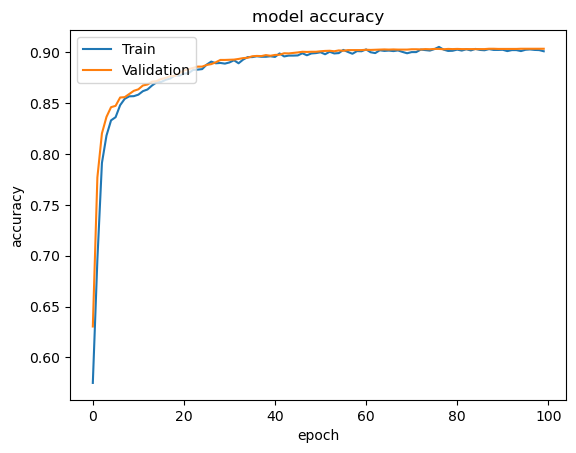

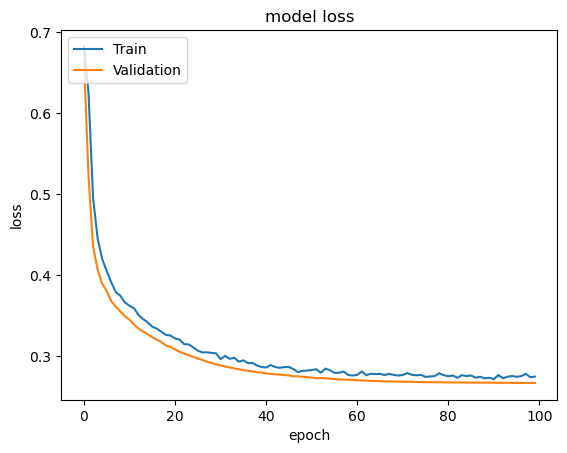

In [105]:
plt.plot(predicted.history['accuracy'])
plt.plot(predicted.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(predicted.history['loss'])
plt.plot(predicted.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

That is much better. Let's make predictions on the data that will be uploaded to Kaggle:

In [121]:
submitme = model_rnn.predict(submitdf)

327/327 [==============================] - 2s 7ms/step


In [149]:
submitme = submitme.reshape(submitme.shape[0], )
submitmefinal = []
for i in range(0,len(submitme)):
    submitmefinal.append(round(submitme[i]))
test["target"] = submitmefinal
test = test.drop(columns = ['text','cleanedtweet'])
test.to_csv(fp + "predictions_upload_me.csv",index = False)

## Step 5: Conclusion

90% accuracy is great compared to our first model. I think this project does a great job of illustrating how important it is to explore different modeling approaches and refine and tune your models and hyperameters. Allowing a good number of epochs so that the model can traing and refine itself is a crucial step in the modeling process, which underscores the need for high performance computing systems that we can explore in the high performace computing class that University of Colorado puts out. For futher analysis, I could play with the learning rates and attempt a GRU model, but for now that would lie outside the scope of this project.